# Control of a Driven Qubit System Through Optimization Methods
---

The aim of this project is to implement a procedure to control a driven qubit system through numerical minimization. The experimental protocol is:

1. **System preparation**: Prepare the qubit in the ground state and the cavity in the vacuum state. The initial condition is set to Resonator-Transmon coupling with interaction with a drive field;
2. **Control**: Apply a control field to the system. The control field is a classical field that interacts with the qubit and the cavity. The control field is applied for a certain time. The control field is set to be a generic function expanded in a Fourier series. The control field is a function of the time and the Fourier coefficients;
3. **Measurement**: Measure the qubit and the cavity. The measurement is performed by measuring the occupation of the qubit;
4. **Cost function**: The cost function is calculated from the measurement. The cost function is a function of the control field. The cost function is a measure of the distance between the target state and the actual state of the system;
5. **Optimization**: Minimize the loss function with respect to the control field. The optimization is performed by using a numerical minimization algorithm. The optimization is performed by using the loss function as the objective function. The optimization is performed by using the control field as the variable.

---
## System preparation
---

In terms of Quantum Information Science, superconducting quantum circuits are a promising platform for quantum computing. Within this framework, the transmon qubit is a widely used system, where it can be coupled to a superconducting resonator, whereas the interaction between the qubit and the resonator can be used to manipulate the dynamics of the qubit. The applications for this control can be visualized in the implementation of quantum gates, quantum algorithms, quantum metrology, quantum simulation, among others.

The description of the system is based upon the transmon-resonator coupling. Given that, the definition of the parameters includes the resonator as a cavity coupled to the two-level system transmon (qubit). The starting framework is the ground state with the cavity frequency away from the qubit frequency (treated afterward with the detuning parameter).

The derivation to be used of a coupled Hamiltonian for a quantum system involving the interaction between a transmon qubit and a cavity is as follows:

$$
\hat{H} = \hbar\omega_R \hat{a}^\dagger \hat{a} - \frac{\hbar\omega_T}{2}\hat{\sigma}_z - \hbar g(\hat{\sigma}_+ - \hat{\sigma}_-)(\hat{a}^\dagger - \hat{a})
$$

A new Hamiltonian is defined regarding driven interactions. The idea is to extend the application to manipulating the dynamics of a system through an applied signal. The term to be added to the Hamiltonian of the system is as follows:

$$
    \hat{H}_{\text{drive}} = -\frac{C_g Q_{\text{zpf}}}{2(C_\Sigma + C_g)}(V_g^* - V_g)(\hat{b}^\dagger-\hat{b})
$$

The system preparation in the resonant regime is defined by the following parameters:

$$
    \omega_R = \omega_T = 1.0 \ \text{GHz}
$$

$$
    g = 0.01 \ \text{GHz}
$$

In the dispersive regime, the detuning parameter is defined as follows:

$$
    \Delta = \omega_T - \omega_R = -0.8 \ \text{GHz}
$$

Additionally, the parameters of the drive system with estimated values are defined as follows:

$$
    \beta = \frac{C_g }{(C_\Sigma + C_g)} \approx 0.2
$$

$$
    Q_{\text{zpf}} = \sqrt{\frac{\hbar C \omega_r}{2}} \approx 1 \times 10^{-18}
$$

In [1]:
# Libraries import
from qutip import *
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.optimize import minimize

In [2]:
# Defining number of cavity fock states
N = 10 

# Defining the cavity (resonator) frequency
w_R = 1.0 * 2 * np.pi 

# Defining the qubit (transmon) frequency
w_T = 1.0 * 2 * np.pi

# Defining coupling strength  
g = 0.01 * 2 * np.pi 

# Defining the time list
t = np.linspace(0, 10, 200)
# Defining the initial state (lowest energy state of the resonator and qubit)
psi_0 = tensor(fock(N, 0), fock(2, 0))

# Defining the collapse operators
a = tensor(destroy(N), qeye(2)) # cavity annihilation operator
sigma_minus = tensor(qeye(N), destroy(2)) # qubit annihilation operator
sigma_z = tensor(qeye(N), sigmaz()) # qubit sigma_z operator

# Defining the Hamiltonians functions with its respective parameters
def hamiltonian_w_R(w_R: float) -> Qobj:
    """
    Calculates the resonator segment of the Hamiltonian of a driven qubit system with a given resonator frequency.

    Parameters:
    w_R (float): The resonator frequency of the qubit system.

    Returns:
    hamiltonian (qutip.Qobj): The resonator segment of the Hamiltonian of the driven qubit system.
    """
    return w_R * a.dag() * a

def hamiltonian_w_T(w_T: float) -> Qobj:
    """
    Returns the transmon segment of the Hamiltonian of a driven qubit system with a given transmon frequency.

    Parameters:
    w_T (float): The transition frequency of the qubit system.

    Returns:
    Qobj: The transmon segment of the Hamiltonian operator of the driven qubit system.
    """
    return - w_T / 2 * sigma_z

def hamiltonian_g(g: float) -> Qobj:
    """
    Calculate the coupling segment of the Hamiltonian for a driven qubit system.

    Parameters:
    g (float): The coupling strength between the qubit and the cavity.

    Returns:
    Qobj: The coupling segment of the Hamiltonian operator for the driven qubit system.
    """
    return -g * (sigma_minus.dag() - sigma_minus) * (a.dag() - a)

# Defining a Hamiltonian function for a driven system
b = tensor(qeye(N), destroy(2)) # qubit annihilation operator
  
# Defining a parametric Hamiltonian function
H_R = hamiltonian_w_R(w_R)
H_T = hamiltonian_w_T(w_T)
H_g = hamiltonian_g(g)

H = H_R + H_T + H_g

# Defining a Hamiltonian generator/modifying function
def hamiltonian_gen(w_R: float, w_T: float, g: float) -> None:
    """
    Generates the Hamiltonian for a driven qubit system.

    Args:
        w_R (float): Resonator frequency.
        w_T (float): Transmon frequency.
        g (float): Coupling strength.

    Returns:
        None
    """
    global H_R, H_T, H_g, H
    
    H_R = hamiltonian_w_R(w_R)
    H_T = hamiltonian_w_T(w_T)
    H_g = hamiltonian_g(g)

    H = H_R + H_T + H_g

---
## Control and Measurement
---

### Fourier Series Expansion

The control is performed by applying a classical field to the system. The control field is a function of the time and the Fourier coefficients. The control field is applied for a certain time. The control field is set to be a generic function expanded in a Fourier series. The control field is a function of the time and the Fourier coefficients.

The measurement is performed by measuring the occupation of the qubit. The loss function is calculated from the measurement. The loss function is a function of the control field. The loss function is a measure of the distance between the target state and the actual state of the system.

Hence, a time-dependent Hamiltonian is defined as follows:

$$
\hat{H}(t) = \hbar\omega_R \hat{a}^\dagger \hat{a} - \frac{\hbar\omega_T}{2}\hat{\sigma}_z - \hbar g(\hat{\sigma}_+ - \hat{\sigma}_-)(\hat{a}^\dagger - \hat{a}) - \frac{C_g Q_{\text{zpf}}}{2(C_\Sigma + C_g)}(V_g^* - V_g)(\hat{b}^\dagger-\hat{b})
$$

Whereas it is measured and the control is made by the manipulation of the term $\hat{V}_g + \hat{V}_g^*$ as it is expanded in terms of the Fourier series. 

In [ ]:
def fourier_input(t: np.ndarray, coeffs: np.ndarray) -> np.ndarray: 
    """
    Calculates the Fourier series representation of an input signal at time t.

    Parameters:
    t (float): The time at which to evaluate the Fourier series.
    coeffs (list): A list of Fourier coefficients.

    Returns:
    complex: The Fourier series representation of the input signal at time t.
    """
    coeff_sum = 0
    i = - len(coeffs) // 2
    for coeff in coeffs:        
        coeff_sum += coeff * np.exp(1j * 2* np.pi * i/period * t)
        i += 1
    return coeff_sum

In [31]:
hamiltonian_gen(w_R, w_T, g)

@njit
def control_series(t: np.ndarray, coeffs: np.ndarray) -> complex: 
    """
    Calculates the control series for a driven qubit system.

    Parameters:
    t (np.ndarray): The time values at which to evaluate the control series.
    coeffs (np.ndarray): The coefficients of the control series.

    Returns:
    complex: The calculated control series value at each time point.
    """
    coeff_sum = 0
    i = - len(coeffs) // 2
    for coeff in coeffs:
        coeff_sum += coeff * np.exp(1j * 2 * np.pi * i/period * t)
        i += 1
    return np.conjugate(coeff_sum) - coeff_sum

def hamiltonian_Drive_coeff(t: np.ndarray, args: dict) -> complex:
    """
    Calculates the coefficient for the driven qubit system's Hamiltonian.

    Parameters:
    - t: np.ndarray
        The time array.
    - args: dict
        A dictionary containing the necessary arguments for the calculation.

    Returns:
    - complex
        The coefficient for the driven qubit system's Hamiltonian.
    """
    return -1 * (args["f_V_aux"](t, args["coeffs_list"]))

def f_V(t: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    """
    Calculate the expectation value of sigma_minus.dag() * sigma_minus for a driven qubit system.

    Parameters:
    t (np.ndarray): Array of time values.
    coeffs (np.ndarray): Array of coefficients.

    Returns:
    np.ndarray: Array of expectation values.

    """
    H_Drive = [H, [b.dag() - b, hamiltonian_Drive_coeff]]
    args = {"f_V_aux": control_series, "coeffs_list": coeffs}
    qevo_Drive = QobjEvo(H_Drive, args=args)
    
    return mesolve(qevo_Drive, psi_0, t, e_ops=[sigma_minus.dag() * sigma_minus]).expect[0]


In [4]:
# Definition of a random minimization procedure
def random_minimize(vector_size: int = 32, max_iter: int = 6) -> minimize:
    """
    Randomly minimizes the cost function using the L-BFGS-B optimization method.

    Args:
        vector_size (int): The size of the vector used for optimization. Default is 32.
        max_iter (int): The maximum number of iterations. Default is 6.

    Returns:
        minimize: The global minimum found by the optimization process.
    """
    minimum_global = minimize(cost, np.random.uniform(low = 0, high = 1, size = vector_size), method = "L-BFGS-B")
    partial = minimum_global
    print(len(minimum_global.x), minimum_global.fun)

    for _ in range(max_iter - 1):
        partial = minimize(cost, np.random.uniform(low = 0, high = 1, size = vector_size), method = "L-BFGS-B")
        print(len(partial.x), partial.fun)
        if partial.fun < minimum_global.fun:
            minimum_global = partial

    return minimum_global

In [29]:
# Definition of the PlotFig class for the plots
class PlotFig:
    """
    A class for plotting figures related to qubit control.

    Attributes:
        t (array-like): The time values.
        coeffs (array-like): The coefficients.
        period (float): The period.
        sigma (float, optional): The sigma value for the Gaussian function. Default is 1.
        figSizeXcm (float, optional): The figure size in centimeters along the x-axis. Default is 30.
        figSizeYcm (float, optional): The figure size in centimeters along the y-axis. Default is 28.
        titleFontSize (int, optional): The font size for the title. Default is 34.
        labelFontSize (int, optional): The font size for the labels. Default is 28.
        axisFontSize (int, optional): The font size for the axis ticks. Default is 22.
    """

    def __init__(self, t, coeffs, period, sigma=1, figSizeXcm=30, figSizeYcm=28, titleFontSize=34, labelFontSize=28, axisFontSize=22):
        self.t = t
        self.coeffs = coeffs
        self.period = period
        self.sigma = sigma
        self.figSizeXcm = figSizeXcm
        self.figSizeYcm = figSizeYcm
        self.titleFontSize = titleFontSize
        self.labelFontSize = labelFontSize
        self.axisFontSize = axisFontSize
        self.figSizeXinches = self.figSizeXcm/2.54
        self.figSizeYinches = self.figSizeYcm/2.54
        self.t_middle = self.t[int(len(t)/2)]

    def _plot(self, t, coeffs, f_t, title, label, save_fig):
        """
        Internal method for plotting the figures.

        Args:
            t (array-like): The time values.
            coeffs (array-like): The coefficients.
            f_t (array-like): The function values.
            title (str): The title of the figure.
            label (str): The label for the function.
            save_fig (str): The file path to save the figure.
        """
        plt.rcParams['font.family'] = "CMU Serif"
        plt.rcParams['text.usetex'] = True
        plt.rcParams['axes.linewidth'] = 1.0
        plt.rcParams["legend.loc"] = 'best'
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(self.figSizeXinches, self.figSizeYinches))
        # First plot
        ax1.set_title(title, fontsize=self.titleFontSize)
        ax1.xaxis.set_tick_params(width=1.0)
        ax1.yaxis.set_tick_params(width=1.0)
        ax1.tick_params(axis='both', which='major', labelsize=self.axisFontSize)
        ax1.tick_params(axis='both', which='minor', labelsize=self.axisFontSize)
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax1.plot(t, f_V(t, coeffs), label="Controlled Qubit", color='green')
        ax1.plot(t, f_t, label=label, color='blue', linestyle='--')
        ax1.set_xlabel('t (ns)', fontsize=self.labelFontSize)
        ax1.set_ylabel('Occ Prob', fontsize=self.labelFontSize)
        ax1.legend(loc=0, fontsize=self.axisFontSize)

        # Second plot
        ax2.set_title(r"\Huge{\textbf{Tension Input (Passband)}}", fontsize=self.titleFontSize)
        ax2.xaxis.set_tick_params(width=1.0)
        ax2.yaxis.set_tick_params(width=1.0)
        ax2.tick_params(axis='both', which='major', labelsize=self.axisFontSize)
        ax2.tick_params(axis='both', which='minor', labelsize=self.axisFontSize)
        ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax2.plot(t, fourier_input(t, coeffs)/10, label=f"V(t)", color='#8B0000')
        ax2.set_xlabel('t (ns)', fontsize=self.labelFontSize)
        ax2.set_ylabel('Tension (nV)', fontsize=self.labelFontSize)
        ax2.legend(loc=0, fontsize=self.axisFontSize)

        plt.tight_layout()
        plt.show()
        fig.savefig(save_fig)

    def plot_sint(self):
        """
        Plot a figure for the sinoidal function.
        """
        self.title = r'\textbf{Sinoidal Function}' + f"\n" + r"\Huge{\textbf{Qubit Control}}"
        self.f_t = np.abs(np.sin(self.t))
        self.label = f"$|$sin(t)$|$"
        self.save_fig = f"./review/control_sinoidal.pdf"
        self._plot(self.t, self.coeffs, self.f_t, self.title, self.label, self.save_fig)

    def plot_gauss(self):
        """
        Plot a figure for the Gaussian function.
        """
        self.title = r'\textbf{Gaussian Function}' + f"\n" + r"\Huge{\textbf{Qubit Control}}"
        self.f_t = np.exp(-((self.t-self.t_middle)/self.sigma)**2)
        self.label = r"Gaussian(t)$_{\sigma = 1}$"
        self.save_fig = f"./review/control_gaussian.pdf"
        self._plot(self.t, self.coeffs, self.f_t, self.title, self.label, self.save_fig)

    def plot_rect(self):
        """
        Plot a figure for the rectangular function.
        """
        self.title = r'\textbf{Rectangular Function}' + f"\n" + r"\Huge{\textbf{Qubit Control}}"
        self.f_t = np.zeros(len(t))
        self.f_t[int(len(t)/3):int(2*len(t)/3)] = 1
        self.label = r"Rectangular(t)$_{\tau = 10/3}$"
        self.save_fig = f"./review/control_rect.pdf"
        self._plot(self.t, self.coeffs, self.f_t, self.title, self.label, self.save_fig)

---
## Cost Function and Optimization
---

A cost function is defined as a measure of the distance between the target state and the actual state of the system. The cost function is calculated from the measurement. The cost function is a function of the control field. The cost function is a measure of the distance between the target state and the actual state of the system.

Nevertheless, different cost functions can be defined depending on the minimization algorithm to be used and the intend output to be achieved. From this point on, different cost functions are defined and the minimization algorithm is applied to the system depending on the output to be achieved.

### Minimization 1: Achieve a frequency adjusted sine wave output with L-BFGS-B minimization algorithm in Resonant Regime
---

In [6]:
# Sinoidal parameters
factor = 1.0
period = 2 * np.pi / factor

# Defining the desired function
f_t = np.abs(np.sin(factor * t))

# Cost function
def cost(coeffs: np.ndarray) -> float:
    """
    Calculates the cost function for a given set of coefficients.

    Parameters:
    coeffs (np.ndarray): An array of coefficients.

    Returns:
    float: The calculated cost value.
    """
    return (1/len(t)) * np.sum((f_V(t, coeffs) - f_t)**2)

In [7]:
# Minimization procedure
res_32_LB_sint = random_minimize(vector_size = 32, max_iter = 6)

32 0.003241707263942638
32 0.0009096986051013922
32 0.0008788378155402002
32 0.0009097453493722138
32 0.0009651393761210369
32 0.0009651994394711202


In [8]:
# Save the results of the minimization procedure
np.save("./review/res_32_LB_sint.npy", res_32_LB_sint)

c:\Users\denys\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\denys\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


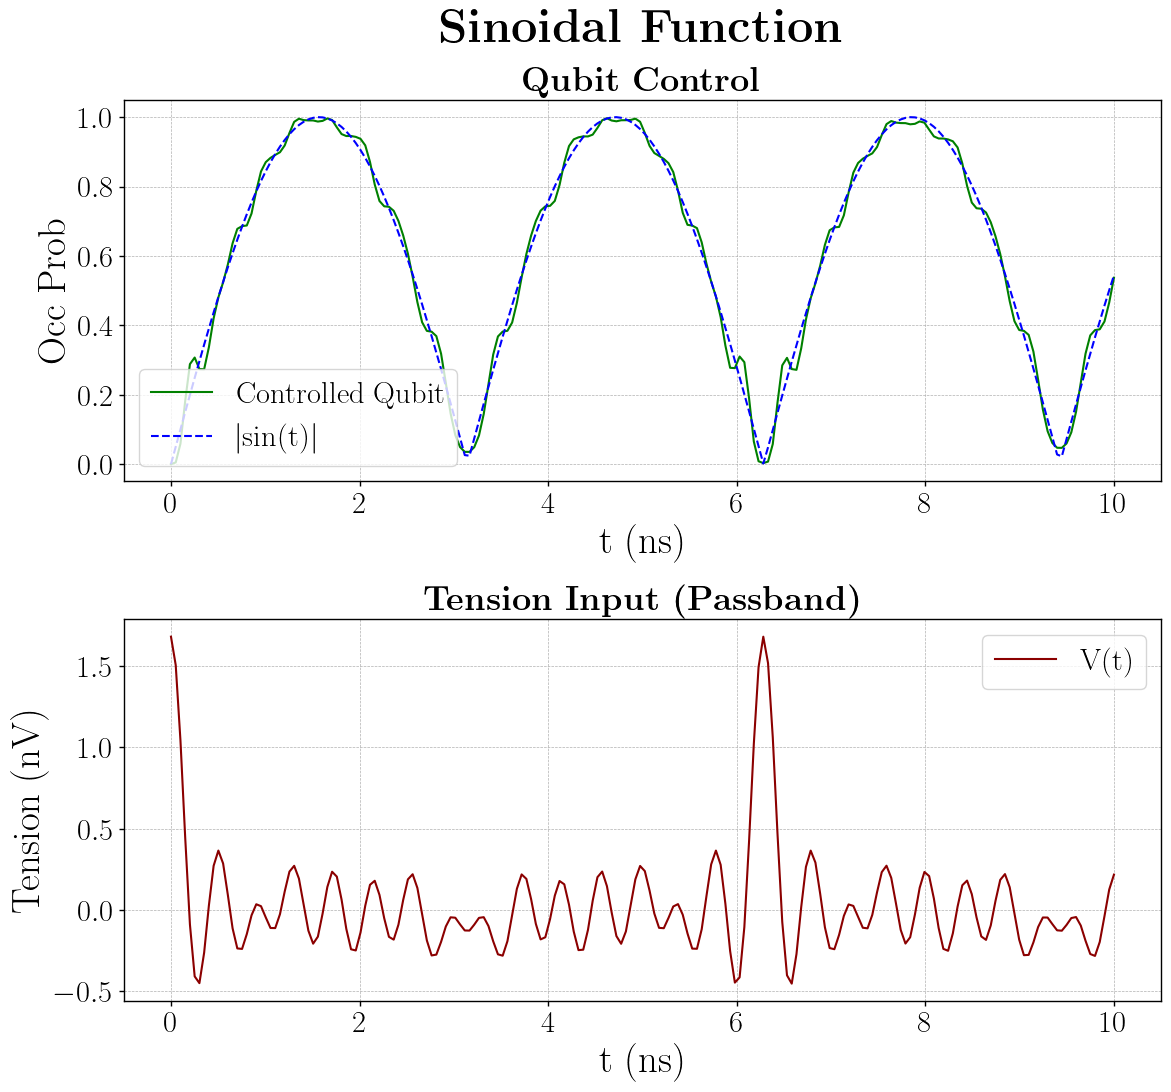

In [9]:
# Load and plot the results of the minimization procedure
res_32_LB_sint = np.load("./review/res_32_LB_sint.npy", allow_pickle=True).item()
plot_sint = PlotFig(t, res_32_LB_sint.x, period)
plot_sint.plot_sint()

### Minimization 2: Achieve an adjusted gaussian wave output with L-BFGS-B minimization algorithm in Resonant Regime
---


In [32]:
hamiltonian_gen(w_R, w_T, g)

@njit
def control_series(t: np.ndarray, coeffs: np.ndarray) -> complex: 
    """
    Calculate the control series for a given time array and coefficients.

    Parameters:
    t (np.ndarray): Array of time values.
    coeffs (np.ndarray): Array of coefficients.

    Returns:
    complex: The calculated control series value.
    """
    coeff_sum = 0
    i = - len(coeffs) // 2
    for coeff in coeffs:
        coeff_sum += coeff * np.exp(1j * 2 * np.pi * i/period * t)
        i += 1
    return np.conjugate(coeff_sum) - coeff_sum

def hamiltonian_Drive_coeff(t: np.ndarray, args: dict) -> complex:
    """
    Calculates the coefficient for the driven qubit system's Hamiltonian.

    Parameters:
    - t: np.ndarray
        The time array.
    - args: dict
        A dictionary containing the necessary arguments for the calculation.

    Returns:
    - complex
        The calculated coefficient for the Hamiltonian.
    """
    return -1 * (args["f_V_aux"](t, args["coeffs_list"]))

def f_V(t: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    """
    Calculate the expectation value of the operator sigma_minus.dag() * sigma_minus
    for a driven qubit system.

    Parameters:
    t (np.ndarray): Array of time values.
    coeffs (np.ndarray): Array of coefficients.

    Returns:
    np.ndarray: Array of expectation values.
    """
    H_Drive = [H, [b.dag() - b, hamiltonian_Drive_coeff]]
    args = {"f_V_aux": control_series, "coeffs_list": coeffs}
    qevo_Drive = QobjEvo(H_Drive, args=args)
    
    return mesolve(qevo_Drive, psi_0, t, e_ops=[sigma_minus.dag() * sigma_minus]).expect[0]


In [19]:
# Gaussian parameters
sigma = 1.0
t_middle = t[int(len(t)/2)]
period = t[-1]

# Defining the desired function
f_t = np.exp(-((t-t_middle)/sigma)**2)

# cost function
def cost(coeffs: np.ndarray) -> float:
    """
    Calculate the cost function for a given set of coefficients.

    Parameters:
    coeffs (np.ndarray): An array of coefficients.

    Returns:
    float: The value of the cost function.
    """
    return (1/len(t)) * np.sum((f_V(t, coeffs) - f_t)**2)

In [12]:
# Minimization procedure
res_B_gaussian_fourier_input_32 = random_minimize(vector_size = 32, max_iter = 6)

32 0.0005931714697611774
32 0.0005931504631673157
32 0.00041471086454081957
32 0.03801817965513571
32 0.0004146555633990626
32 0.00041464982511610826


In [20]:
# Save the results of the minimization procedure
np.save("./review/res_B_gaussian_fourier_input_32.npy", res_B_gaussian_fourier_input_32)

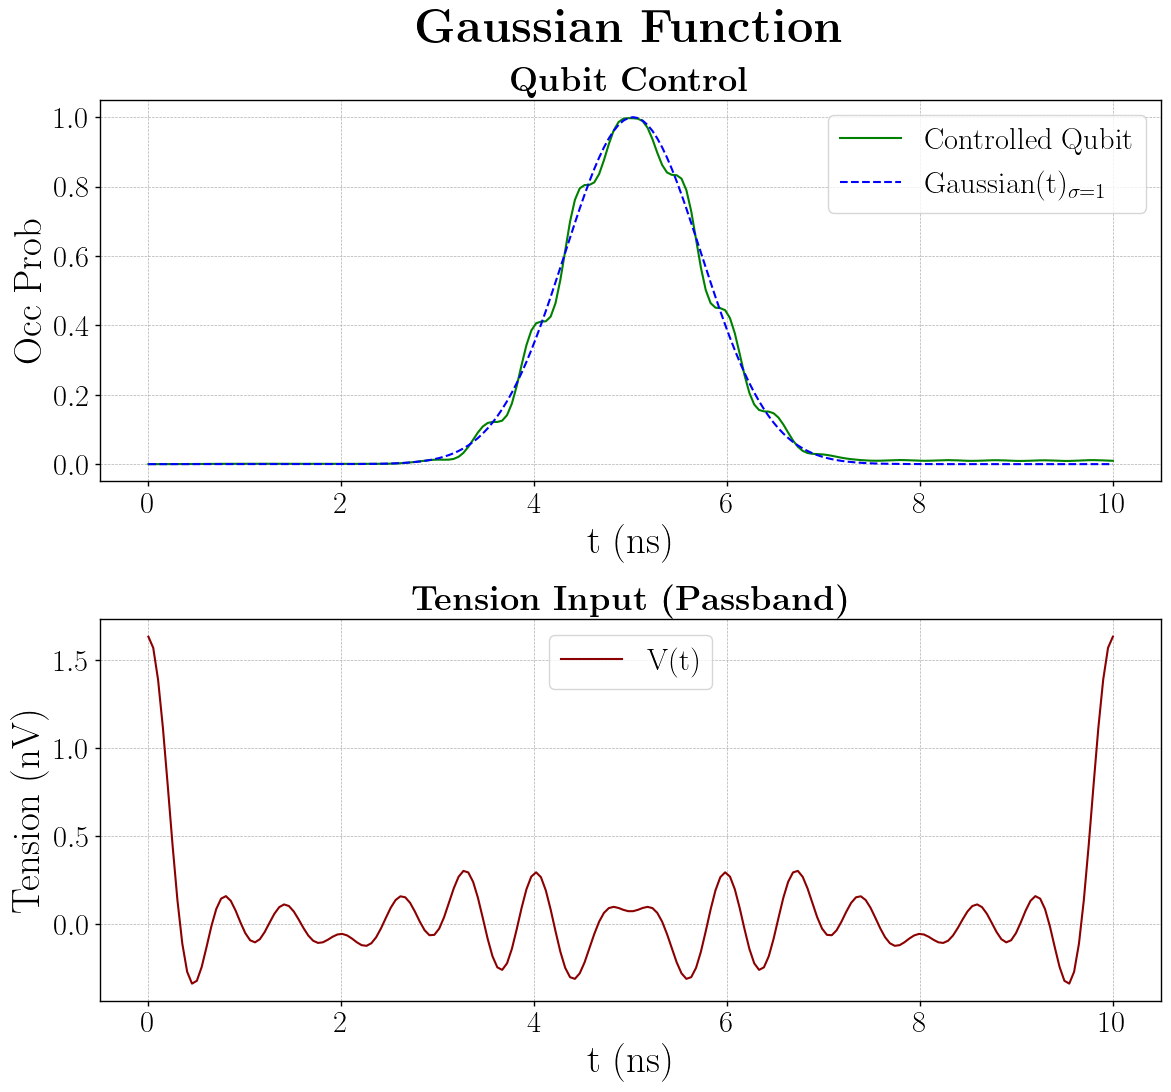

In [30]:
# Load the results of the minimization procedure
res_B_gaussian_fourier_input_32 = np.load("./review/res_B_gaussian_fourier_input_32.npy", allow_pickle=True).item()
plot_gauss = PlotFig(t, res_B_gaussian_fourier_input_32.x, period, sigma)
plot_gauss.plot_gauss()

### Minimization 3: Achieve an adjusted rectangular wave output with L-BFGS-B minimization algorithm in Resonant Regime
---


In [23]:
hamiltonian_gen(w_R, w_T, g)

@njit
def control_series(t: np.ndarray, coeffs: np.ndarray) -> complex: 
    """
    Calculate the control series for a driven qubit system.
    
    Parameters:
        t (np.ndarray): Array of time values.
        coeffs (np.ndarray): Array of coefficients.
        
    Returns:
        complex: The control series value.
    """
    coeff_sum = 0
    i = - len(coeffs) // 2
    for coeff in coeffs:
        coeff_sum += coeff * np.exp(1j * 2 * np.pi * i/period * t)
        i += 1
    return np.conjugate(coeff_sum) - coeff_sum

def hamiltonian_Drive_coeff(t: np.ndarray, args: dict) -> complex:
    """
    Calculate the coefficient for the driven qubit system's Hamiltonian.

    Parameters:
    - t: np.ndarray
        The time array.
    - args: dict
        A dictionary containing the necessary arguments for the calculation.

    Returns:
    - complex
        The calculated coefficient for the Hamiltonian.
    """
    return -1 * (args["f_V_aux"](t, args["coeffs_list"]))

def f_V(t: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
    """
    Calculate the expectation value of sigma_minus.dag() * sigma_minus for a driven qubit system.

    Parameters:
    - t (np.ndarray): Array of time values.
    - coeffs (np.ndarray): Array of coefficients.

    Returns:
    - np.ndarray: Array of expectation values.

    """
    H_Drive = [H, [b.dag() - b, hamiltonian_Drive_coeff]]
    args = {"f_V_aux": control_series, "coeffs_list": coeffs}
    qevo_Drive = QobjEvo(H_Drive, args=args)
    
    return mesolve(qevo_Drive, psi_0, t, e_ops=[sigma_minus.dag() * sigma_minus]).expect[0]


In [24]:
def rect_vector_gen():
    """
    Generates a rectangular pulse vector.

    Returns:
    vector (numpy.ndarray): A numpy array representing a rectangular pulse vector.
    """
    vector = np.zeros(len(t))
    vector[int(len(t)/3):int(2*len(t)/3)] = 1
    return vector

# Assign the generated rectangular pulse vector the variable rect_vector.
rect_vector = rect_vector_gen()

# Cost function
def cost(coeffs: np.ndarray) -> float:
    """
    Calculate the cost function for a given set of coefficients.

    Parameters:
    coeffs (np.ndarray): An array of coefficients.

    Returns:
    float: The value of the cost function.
    """
    return (1/len(t)) * np.sum((f_V(t, coeffs) - rect_vector)**2)

In [25]:
# Minimization procedure
res_B_step_fourier_input_40 = random_minimize(vector_size = 40, max_iter = 6)

40 0.004580632278200496
40 0.004580635446715628
40 0.00458068217018614
40 0.004580654293890419
40 0.0045806545403457
40 0.004580626743480032


In [26]:
# Save the results of the minimization procedure
np.save("./review/res_B_step_fourier_input_40.npy", res_B_step_fourier_input_40)

c:\Users\denys\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\denys\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


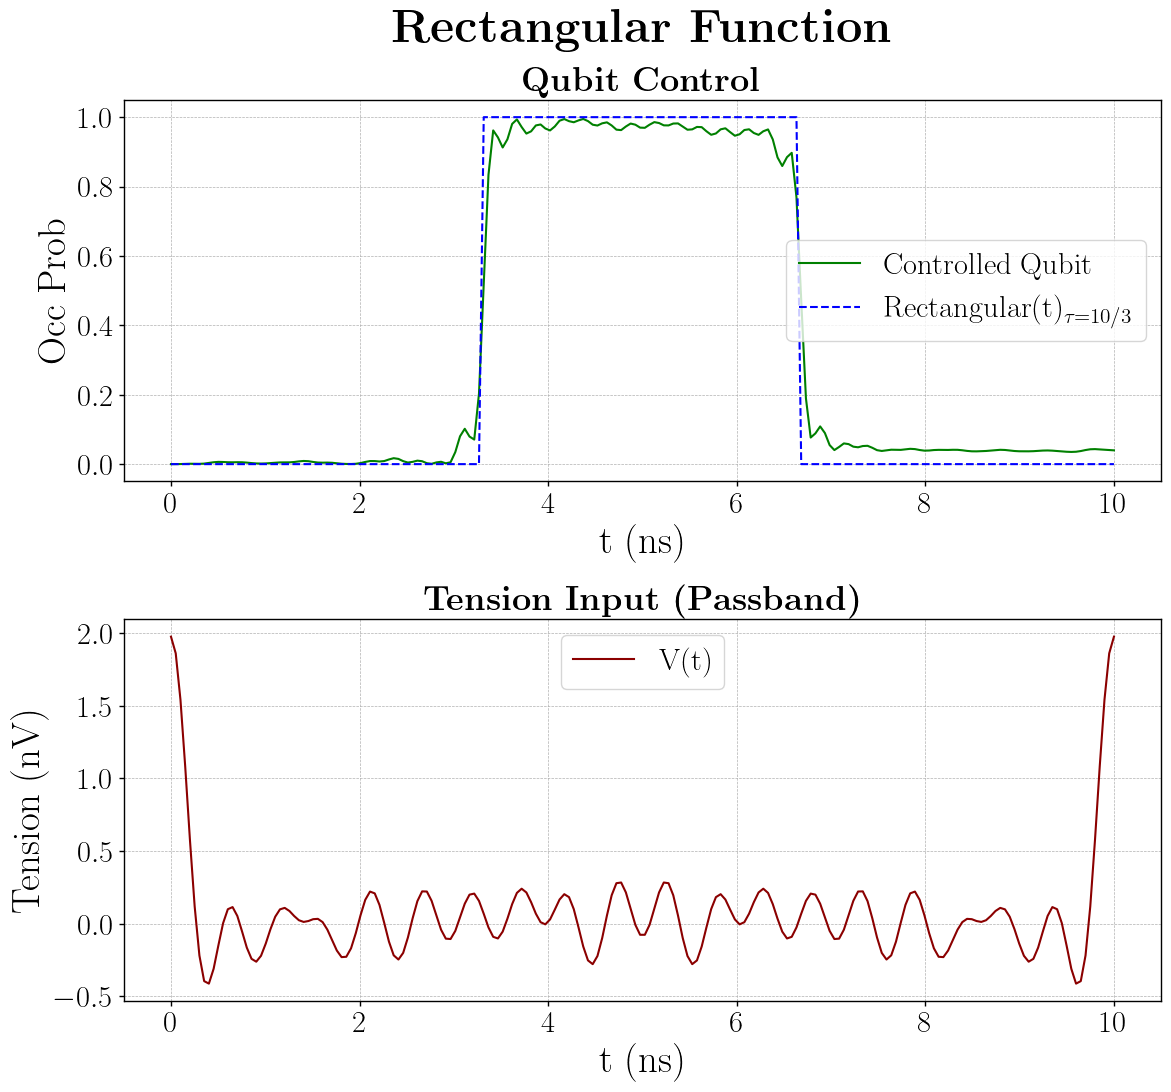

In [27]:
# Load the results of the minimization procedure
res_B_step_fourier_input_40 = np.load("./review/res_B_step_fourier_input_40.npy", allow_pickle=True).item()
plot_rect = PlotFig(t, res_B_step_fourier_input_40.x, period)
plot_rect.plot_rect()